In [6]:
import time
import os
import datetime
import pandas as pd
import numpy as np
import collections
%matplotlib inline
import matplotlib.pyplot as plt
import math
import sys
from copy import copy
import random
import xgboost as xgb

project_name = "rossmann_store_sales"
pd.set_option('display.max_columns', None)

###Helpful functions

In [7]:
def save_submission(idx, preds, filename):
    submission = pd.DataFrame({"Id": idx, "Sales": preds})
    filename = os.path.expandvars("%KagglePath%\\" + project_name + "\\results\\" + filename)
    submission.to_csv(filename, index=False)

In [8]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(y, yhat):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

###Load data

In [9]:
root_path = os.path.expandvars("%KagglePath%\\" + project_name)

In [10]:
train = pd.read_csv(os.path.join(root_path, "train.csv"), 
                    dtype={"StateHoliday": str, "Open": np.int32}).fillna("")
train["Date"] = pd.to_datetime(train["Date"])
train["LogSales"] = np.log(train["Sales"])
start_date = np.min(train.Date)
train["Day"] = 0
for i, row in train.iterrows():
    train.set_value(i, "Day", (row["Date"] - start_date).days)
    
test = pd.read_csv(os.path.join(root_path, "test.csv"), dtype={"StateHoliday": str}).fillna("")
test["Date"] = pd.to_datetime(test["Date"])
test.ix[test.Open == "","Open"] = 1.0
test["Open"] = test["Open"].astype(int)
idx = test.Id.values
test["Day"] = 0
for i, row in test.iterrows():
    test.set_value(i, "Day", (row["Date"] - start_date).days)

store = pd.read_csv(os.path.join(root_path, "store.csv")).fillna("")

###Exploratory analysis

In [11]:
pd.merge(train, store,on='Store').head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,LogSales,Day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,8.568456,941,c,a,1270,9,2008,0,,,
1,1,4,2015-07-30,5020,546,1,1,0,1,8.521185,940,c,a,1270,9,2008,0,,,
2,1,3,2015-07-29,4782,523,1,1,0,1,8.472614,939,c,a,1270,9,2008,0,,,
3,1,2,2015-07-28,5011,560,1,1,0,1,8.519391,938,c,a,1270,9,2008,0,,,
4,1,1,2015-07-27,6102,612,1,1,0,1,8.716372,937,c,a,1270,9,2008,0,,,
5,1,7,2015-07-26,0,0,0,0,0,0,-inf,936,c,a,1270,9,2008,0,,,
6,1,6,2015-07-25,4364,500,1,0,0,0,8.381144,935,c,a,1270,9,2008,0,,,
7,1,5,2015-07-24,3706,459,1,0,0,0,8.217708,934,c,a,1270,9,2008,0,,,
8,1,4,2015-07-23,3769,503,1,0,0,0,8.234565,933,c,a,1270,9,2008,0,,,
9,1,3,2015-07-22,3464,463,1,0,0,0,8.150179,932,c,a,1270,9,2008,0,,,


In [12]:
n_of_weeks = 135

In [13]:
print train.shape
print train.describe()
print test.shape
print test.describe()
print store.shape
print store.describe()

(1017209, 11)
                Store       DayOfWeek           Sales       Customers  \
count  1017209.000000  1017209.000000  1017209.000000  1017209.000000   
mean       558.429727        3.998341     5773.818972      633.145946   
std        321.908651        1.997391     3849.926175      464.411734   
min          1.000000        1.000000        0.000000        0.000000   
25%        280.000000        2.000000     3727.000000      405.000000   
50%        558.000000        4.000000     5744.000000      609.000000   
75%        838.000000        6.000000     7856.000000      837.000000   
max       1115.000000        7.000000    41551.000000     7388.000000   

                 Open           Promo   SchoolHoliday      LogSales  \
count  1017209.000000  1017209.000000  1017209.000000  1.017209e+06   
mean         0.830107        0.381515        0.178647          -inf   
std          0.375539        0.485759        0.383056           NaN   
min          0.000000        0.000000       

In [14]:
train.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,LogSales,Day
0,1,5,2015-07-31,5263,555,1,1,0,1,8.568456,941
1,2,5,2015-07-31,6064,625,1,1,0,1,8.710125,941
2,3,5,2015-07-31,8314,821,1,1,0,1,9.025696,941
3,4,5,2015-07-31,13995,1498,1,1,0,1,9.546455,941
4,5,5,2015-07-31,4822,559,1,1,0,1,8.480944,941
5,6,5,2015-07-31,5651,589,1,1,0,1,8.639588,941
6,7,5,2015-07-31,15344,1414,1,1,0,1,9.638480,941
7,8,5,2015-07-31,8492,833,1,1,0,1,9.046880,941
8,9,5,2015-07-31,8565,687,1,1,0,1,9.055439,941
9,10,5,2015-07-31,7185,681,1,1,0,1,8.879751,941


In [15]:
test.head(10)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Day
0,1,1,4,2015-09-17,1,1,0,0,989
1,2,3,4,2015-09-17,1,1,0,0,989
2,3,7,4,2015-09-17,1,1,0,0,989
3,4,8,4,2015-09-17,1,1,0,0,989
4,5,9,4,2015-09-17,1,1,0,0,989
5,6,10,4,2015-09-17,1,1,0,0,989
6,7,11,4,2015-09-17,1,1,0,0,989
7,8,12,4,2015-09-17,1,1,0,0,989
8,9,13,4,2015-09-17,1,1,0,0,989
9,10,14,4,2015-09-17,1,1,0,0,989


In [16]:
store.head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,,,
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,,,
4,5,a,a,29910,4,2015,0,,,
5,6,a,a,310,12,2013,0,,,
6,7,a,c,24000,4,2013,0,,,
7,8,a,a,7520,10,2014,0,,,
8,9,a,c,2030,8,2000,0,,,
9,10,a,a,3160,9,2009,0,,,


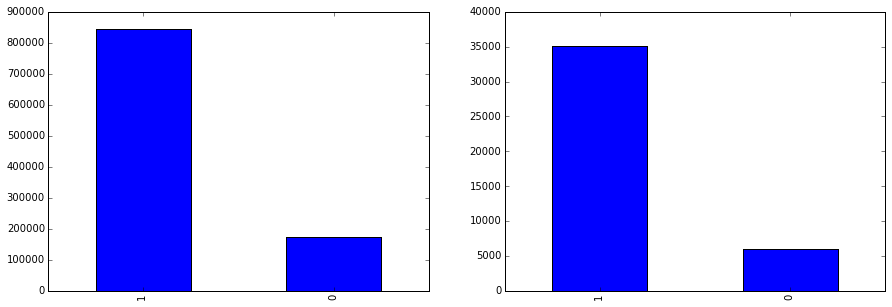

In [17]:
fig, axs = plt.subplots(1,2)
h = train["Open"].value_counts().plot(kind = "bar", ax=axs[0], figsize=(15, 5))
h = test["Open"].value_counts().plot(kind = "bar", ax=axs[1])

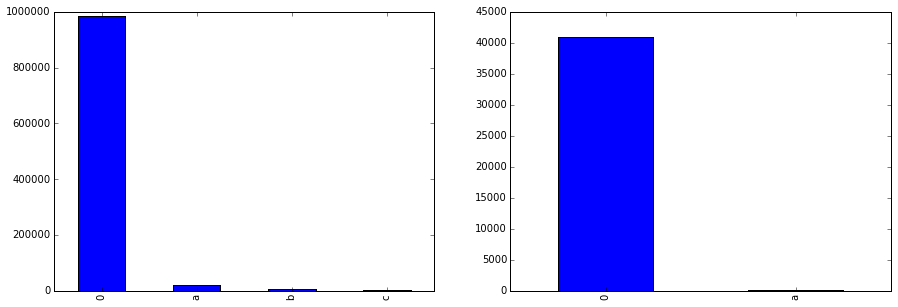

In [18]:
fig, axs = plt.subplots(1,2)
h = train["StateHoliday"].value_counts().plot(kind = "bar", ax=axs[0], figsize=(15, 5))
h = test["StateHoliday"].value_counts().plot(kind = "bar", ax=axs[1])

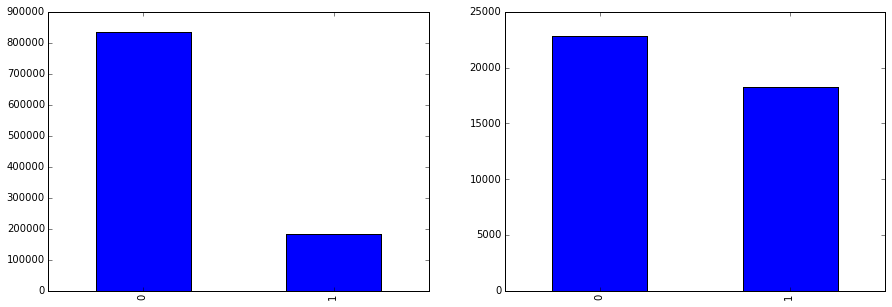

In [19]:
fig, axs = plt.subplots(1,2)
h = train["SchoolHoliday"].value_counts().plot(kind = "bar", ax=axs[0], figsize=(15, 5))
h = test["SchoolHoliday"].value_counts().plot(kind = "bar", ax=axs[1])

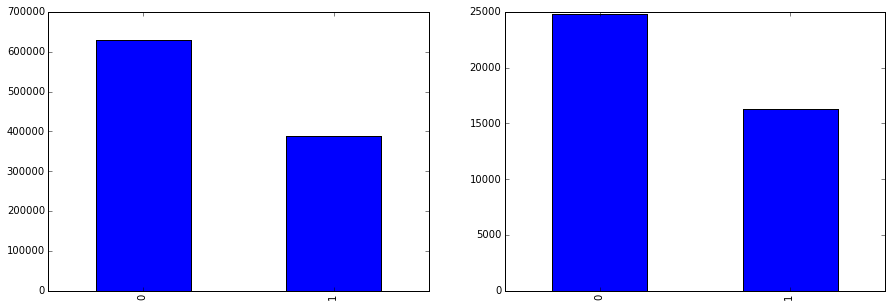

In [20]:
fig, axs = plt.subplots(1,2)
h = train["Promo"].value_counts().plot(kind = "bar", ax=axs[0], figsize=(15, 5))
h = test["Promo"].value_counts().plot(kind = "bar", ax=axs[1])

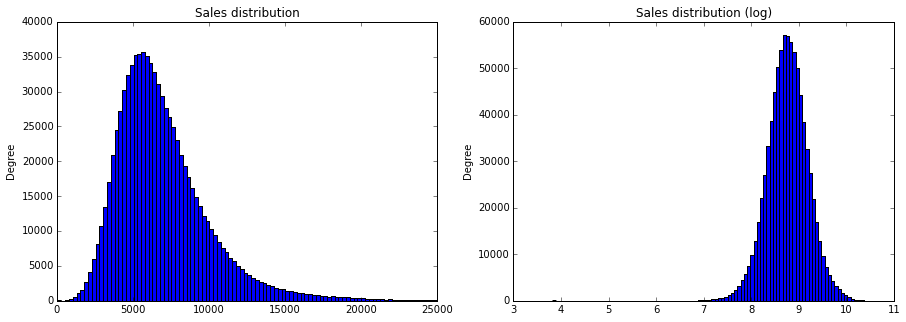

In [21]:
fig, axs = plt.subplots(1,2)
h = train[(train.Sales != 0) & (train.Sales < 25000)]["Sales"].plot(
    kind = "hist", bins=100, ax=axs[0], figsize=(15, 5), title="Sales distribution")
h = np.log(train[(train.Sales != 0)]["Sales"]).plot(
    kind = "hist", bins=100, ax=axs[1], title="Sales distribution (log)")

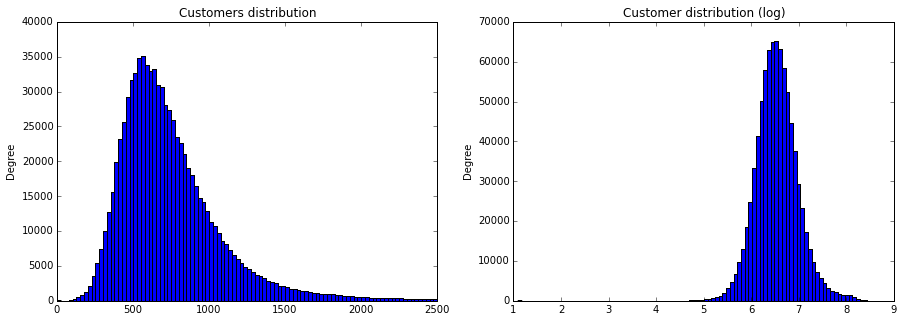

In [22]:
fig, axs = plt.subplots(1,2)
h = train[(train.Customers != 0) & (train.Customers < 2500)]["Customers"].plot(
    kind = "hist", bins=100, ax=axs[0], figsize=(15, 5), title="Customers distribution")
h = np.log(train[(train.Customers != 0)]["Customers"]).plot(
    kind = "hist", bins=100, ax=axs[1], title="Customer distribution (log)")

808


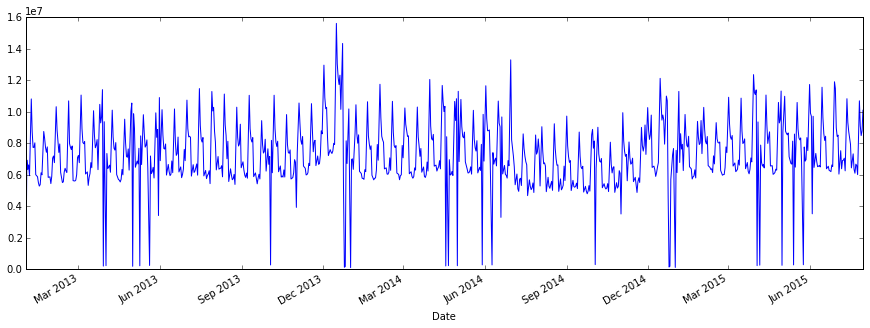

In [23]:
lst = train[(train.DayOfWeek != 7) & (train.Open == 1)].groupby("Date")["Sales"].sum()
print len(lst)
h = lst.plot(kind = "line", figsize=(15, 5))

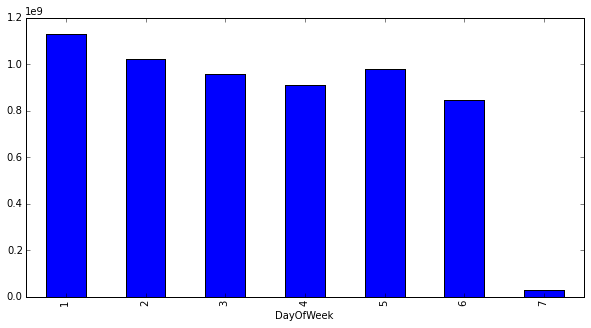

In [24]:
lst = train.groupby("DayOfWeek")["Sales"].sum()
h = lst.plot(kind = "bar", figsize=(10, 5))

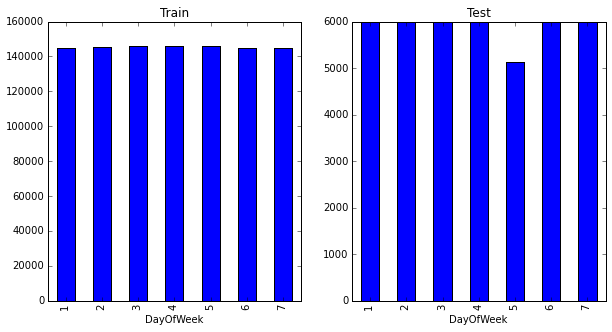

In [25]:
fig, axs = plt.subplots(1,2)
lst = train.groupby("DayOfWeek").size()
h = lst.plot(kind = "bar", figsize=(10, 5), title="Train", ax=axs[0])
lst = test.groupby("DayOfWeek").size()
h = lst.plot(kind = "bar", figsize=(10, 5), title="Test", ax=axs[1])

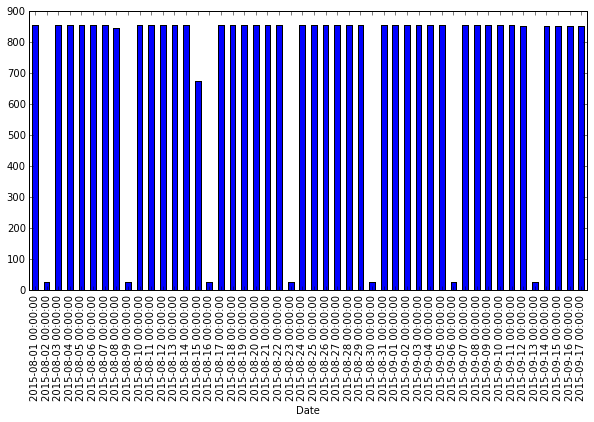

In [26]:
lst = test[(test.Open == 1) & (test.StateHoliday == "0")].groupby("Date").size()
h = lst.plot(kind = "bar", figsize=(10, 5))

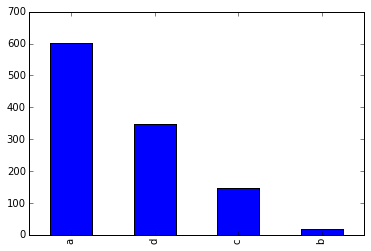

In [27]:
h = store["StoreType"].value_counts().plot(kind = "bar")

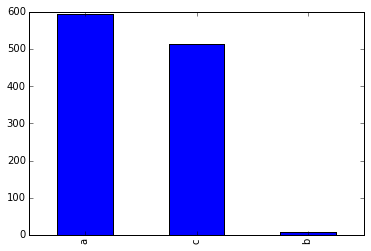

In [28]:
h = store["Assortment"].value_counts().plot(kind = "bar")

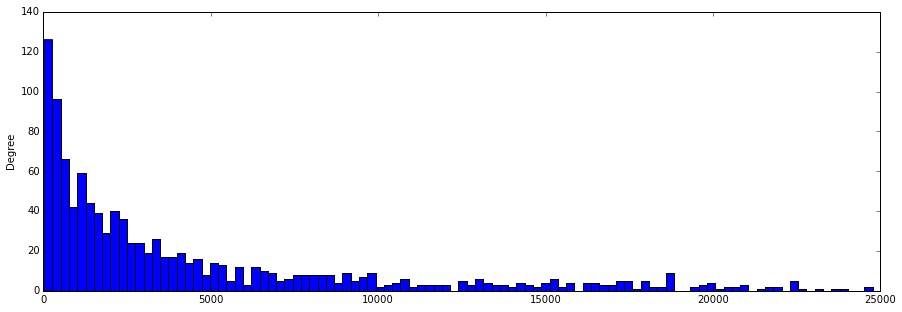

In [29]:
h = store[(store.CompetitionDistance != '') & (store.CompetitionDistance < 25000)]["CompetitionDistance"].plot(kind = "hist", bins=100, figsize=(15, 5))

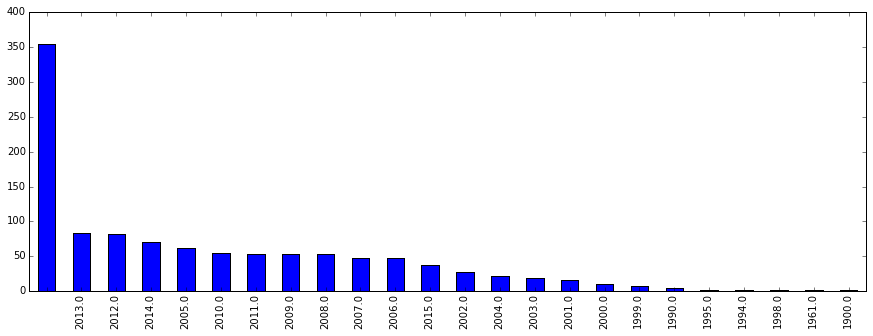

In [30]:
h = store["CompetitionOpenSinceYear"].value_counts().plot(kind = "bar", figsize=(15, 5))

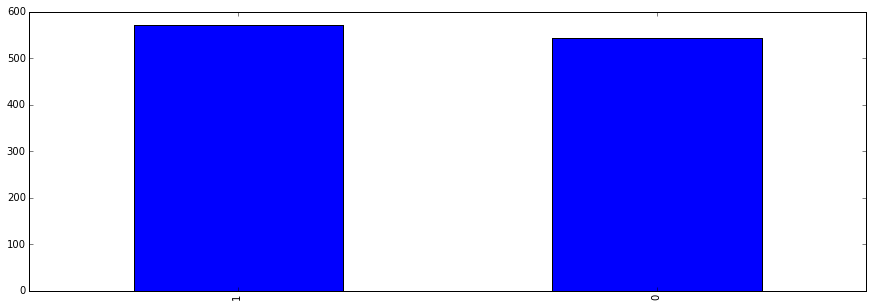

In [31]:
h = store["Promo2"].value_counts().plot(kind = "bar", figsize=(15, 5))

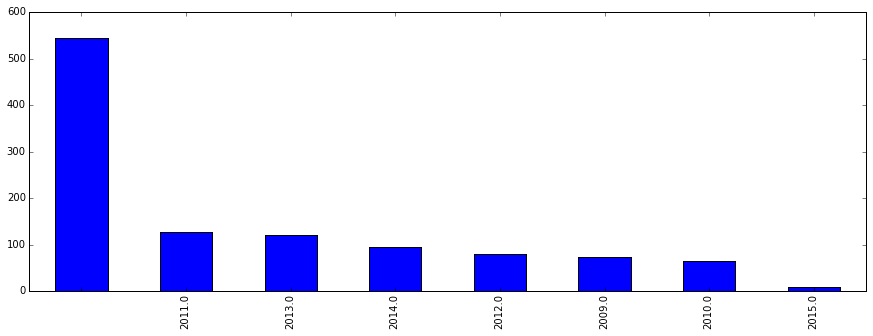

In [32]:
h = store["Promo2SinceYear"].value_counts().plot(kind = "bar", figsize=(15, 5))

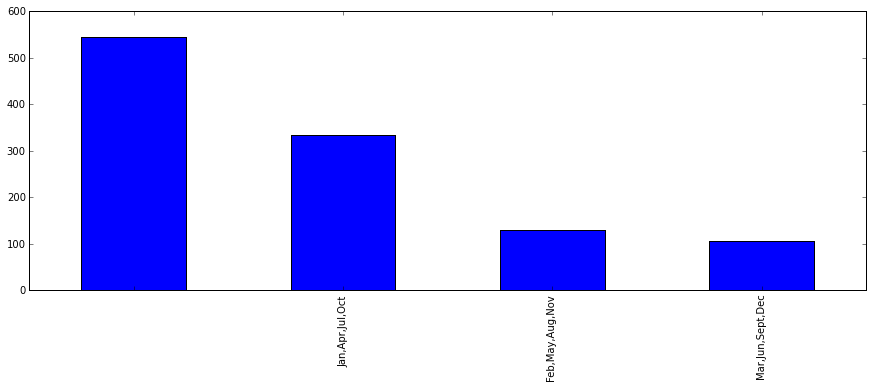

In [33]:
h = store["PromoInterval"].value_counts().plot(kind = "bar", figsize=(15, 5))

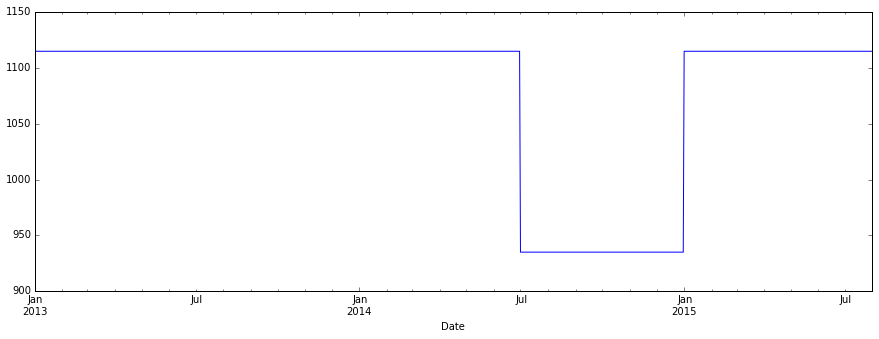

In [34]:
h = train.groupby("Date").size().plot(kind = "line", figsize=(15, 5))

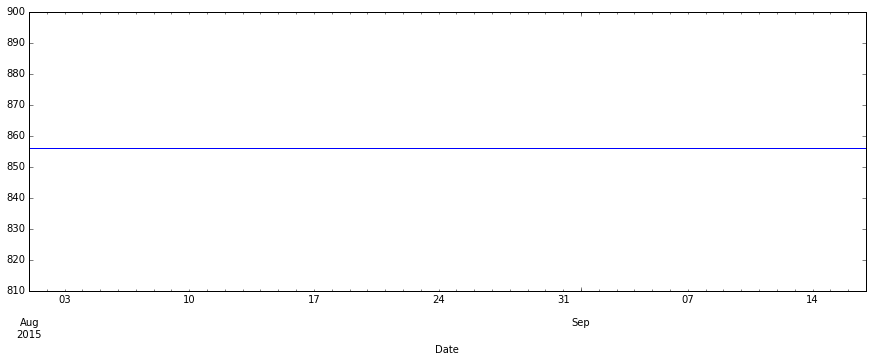

In [35]:
h = test.groupby("Date").size().plot(kind = "line", figsize=(15, 5))

In [36]:
if (len(np.intersect1d(train.groupby("Store")["Store"].unique(), train.groupby("Store")["Store"].unique())) - len(store) == 0):
    print "All stores are both in train and test data sets"

All stores are both in train and test data sets


###Data model

In [37]:
class Store:
    def __init__(self, id, storeType, assortment, 
                 promo2, promo2since_year, promo2since_week, promo2since, promo2interval, 
                 competitor, competitor_since_year, competitor_since_month, competitor_since, 
                 competitor_distance):
        self.id = id
        self.storeType = storeType
        self.assortment = assortment
        self.weeks = []
        self.promo2 = promo2
        self.promo2since_year = promo2since_year
        self.promo2since_week = promo2since_week
        self.promo2since = promo2since
        self.promo2interval = promo2interval
        self.competitor = competitor
        self.competitor_since_year = competitor_since_year
        self.competitor_since_month = competitor_since_month
        self.competitor_since = competitor_since
        self.competitor_distance = competitor_distance
        self.mean_sales = 0
        self.median_sales = 0
        self.mean_customers = 0
        self.meadian_customers = 0
        self.mean_sales_by_weekday = [0] * 7
        self.median_sales_by_weekday = [0] * 7
        self.mean_customers_by_weekday = [0] * 7
        self.median_customers_by_weekday = [0] * 7
        for i in xrange(n_of_weeks):
            self.weeks.append(Week(i))
        self.days = {}
        
    def get_day(self, mktime):
        if mktime not in self.days:
            return None
        return self.days[mktime]
        
class Week:
    def __init__(self, index):
        self.index = index
        self.weekdays = []
        for i in xrange(7):
            self.weekdays.append(Weekday(None, None, i + 1, None, None, None, None, None, False))
    
class Weekday:
    def __init__(self, date, dayNumber, dayOfWeek, storeOpen, stateHoliday, schoolHoliday, sales, customers, hasData):
        self.date = date
        self.dayNumber = dayNumber
        self.dayOfWeek = dayOfWeek
        self.storeOpen = storeOpen
        self.stateHoliday = stateHoliday
        self.schoolHoliday = schoolHoliday
        self.sales = sales
        if self.sales is None or self.sales == "":
            self.sales = 0
        self.customers = customers
        if self.customers is None or self.customers == "":
            self.customers = 0
        self.weekend = 0
        if self.dayOfWeek in [6, 7]:
            self.weekend = 1
        if self.date is not None:
            self.mktime = get_mktime(self.date)
        self.prev_day = None
        self.hasData = hasData
        
def get_mktime(date):
    return int(time.mktime(date.timetuple()))

def get_previous_day_mktime(date):
    return get_mktime(date - datetime.timedelta(days=1))

In [38]:
def loadStoreData(store, train):
    storeSorted = store.sort(["Store"], ascending = [1])
    d = {}
    for i, row in storeSorted.iterrows():
        promo2since = None
        promo2since_year = -1
        promo2since_week = -1
        if (row["Promo2"] == 1):
            promo2since = datetime.datetime(int(row["Promo2SinceYear"]), 1, 1) + datetime.timedelta(days=(row["Promo2SinceWeek"]-1) * 7)
            promo2since_year = int(row["Promo2SinceYear"])
            promo2since_week = row["Promo2SinceWeek"]
        promo2interval = 0
        if (row["PromoInterval"] == "Jan,Apr,Jul,Oct"):
            promo2interval = 1
        elif (row["PromoInterval"] == "Feb,May,Aug,Nov"):
            promo2interval = 2
        if (row["PromoInterval"] == "Mar,Jun,Sept,Dec"):
            promo2interval = 3
        competitor = 0
        competitor_since = None
        competitor_since_year = -1
        competitor_since_month = -1
        if (row["CompetitionOpenSinceYear"] != ''):
            competitor = 1
            competitor_since = datetime.datetime(int(row["CompetitionOpenSinceYear"]), 1, 1) + datetime.timedelta(days=(row["CompetitionOpenSinceMonth"]-1) * 30)
            competitor_since_year = int(row["CompetitionOpenSinceYear"])
            competitor_since_month = int(row["CompetitionOpenSinceMonth"])
        competitor_distance = row["CompetitionDistance"]
        if competitor_distance != "":
            competitor_distance = -1000
        each_store = Store(row["Store"], row["StoreType"], row["Assortment"], 
                           row["Promo2"], promo2since_year, promo2since_week, promo2since, promo2interval, 
                           competitor, competitor_since_year, competitor_since_month, competitor_since, 
                           competitor_distance)
        d[each_store.id] = each_store
    trainSorted = train.sort(["Store", "Date"], ascending = [1, 1])
    for i, row in trainSorted.iterrows():
        storeId = row["Store"]
        day = row["Day"]
        dayOfWeek = row["DayOfWeek"]
        week_index = n_of_weeks - (day / 7) - 1
        weekday = Weekday(row["Date"], row["Day"], row["DayOfWeek"], row["Open"], 
                          row["StateHoliday"], row["SchoolHoliday"], row["Sales"], 
                          row["Customers"], True)
        d[storeId].weeks[week_index].weekdays[dayOfWeek - 1] = weekday
        d[storeId].days[weekday.mktime] = weekday
        prev_day_mktime = get_previous_day_mktime(weekday.date)
        if prev_day_mktime in d[storeId].days:
            weekday.prev_day = d[storeId].days[prev_day_mktime]
    for st in d.itervalues():
        sales = []
        customers = []
        sales_by_weekday = []
        customers_by_weekday = []
        for i in xrange(7):
            sales_by_weekday.append([])
            customers_by_weekday.append([])
        for week in st.weeks:
            for weekday in week.weekdays:
                if (weekday.sales == 0):
                    continue
                sales.append(weekday.sales)
                customers.append(weekday.customers)
                ix = weekday.dayOfWeek - 1
                sales_by_weekday[ix].append(weekday.sales)
                customers_by_weekday[ix].append(weekday.customers)
        st.mean_sales = sum(sales) / len(sales)
        st.mean_customers = sum(customers) / len(customers)
        sales.sort()
        st.median_sales = sales[len(sales) / 2]
        customers.sort()
        st.median_customers = customers[len(customers) / 2]
        for i in xrange(7):
            if len(sales_by_weekday[i]) == 0:
                   continue
            st.mean_sales_by_weekday[i] = sum(sales_by_weekday[i]) / len(sales_by_weekday[i])
            st.mean_customers_by_weekday[i] = sum(customers_by_weekday[i]) / len(customers_by_weekday[i])
            sales_by_weekday[i].sort()
            st.median_sales_by_weekday[i] = sales_by_weekday[i][len(sales_by_weekday[i]) / 2]
            customers_by_weekday[i].sort()
            st.median_customers_by_weekday[i] = customers_by_weekday[i][len(customers_by_weekday[i]) / 2]
    return d

In [39]:
storeData = loadStoreData(store, train) # load store data model

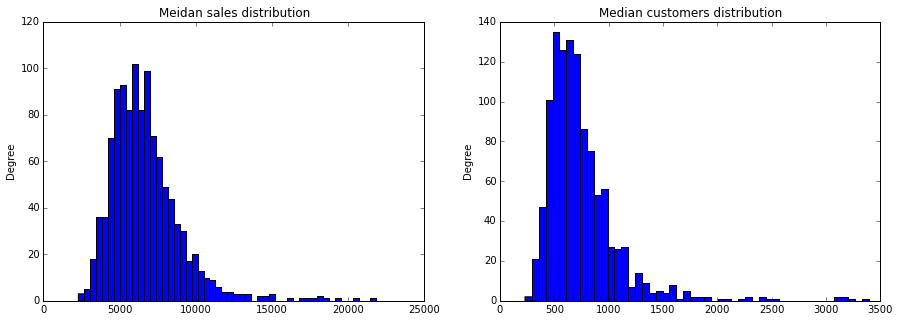

In [35]:
# Check loaded model
fig, axs = plt.subplots(1,2)
h = pd.Series(map(lambda x: x.median_sales, storeData.values())).plot(
    kind = "hist", bins=50, ax=axs[0], figsize=(15, 5), title="Meidan sales distribution")
h = pd.Series(map(lambda x: x.median_customers, storeData.values())).plot(
    kind = "hist", bins=50, ax=axs[1], title="Median customers distribution")

###Simple weights prediction

In [36]:
def get_simple_model(storeData, xp):
    d = {}
    for storeId in storeData:
        w = []
        for i in xrange(7):
            w.append([0.0, 0.0])
        each_store = storeData[storeId]
        for week in each_store.weeks:
            for i in xrange(7):
                weekday = week.weekdays[i]
                if not weekday.hasData or weekday.storeOpen != 1.0 or weekday.stateHoliday != "0":
                    continue
                score = (n_of_weeks - week.index) ** xp
                w[i][0] += weekday.sales * score
                w[i][1] += score
        res = [0.0] * 7
        for i in xrange(7):
            if w[i][1] == 0.0:
                continue
            res[i] = int(w[i][0] / w[i][1])
        d[storeId] = res
    return d
simple_model = {"150": get_simple_model(storeData, 1.50)}

In [37]:
def predict(model, data):
    preds = [0] * data.shape[0]
    j = 0
    for i, row in data.iterrows():
        storeId = int(row["Store"])
        stateHoliday = row["StateHoliday"]
        storeOpen = row["Open"]
        pred = 0
        if storeOpen == 1.0 and stateHoliday == "0":
            dayOfWeek = row["DayOfWeek"]
            pred = model[storeId][dayOfWeek - 1]
        preds[i] = pred
    return preds

In [38]:
predsTrain = dict(map(lambda x: (x, predict(model1[x], train)), model1))
predsTest = dict(map(lambda x: (x, predict(model1[x], test)), model1))

Simple model - about 0.18 on public leaderboard but I will use this model in the future as one
of the feature in the xgboost prediction model 

###Feature engineering

In [77]:
def expandData(data, storeData, preds):
    data = data.copy()
    data["DayOfMonth"] = 0
    data["DayOfCycle"] = 0
    data["MonthPeriod1"] = 0
    data["MonthPeriod2"] = 0
    data["StartOfMonth"] = 0
    data["EndOfMonth"] = 0
    data["DayOfYear"] = 0
    data["Month"] = 0
    data["Year"] = 0
    data["WeekNumber"] = 0
    data["Weekend"] = 0
    data["EvenWeek"] = 0
    data["Competitor"] = 0
    data["CompetitorSinceYear"] = 0
    data["CompetitorSinceMonth"] = 0
    data["CompetitorDistance"] = -1
    data["LogCompetitorDistance"] = -1
    data["Promo2"] = 0
    data["Promo2SinceYear"] = 0
    data["Promo2SinceWeek"] = 0
    data["StateHoliday0"] = 0
    data["StateHolidayA"] = 0
    data["StateHolidayB"] = 0
    data["StateHolidayC"] = 0
    data["StoreType"] = 0
    data["StoreTypeA"] = 0
    data["StoreTypeB"] = 0
    data["StoreTypeC"] = 0
    data["StoreTypeD"] = 0
    data["Assortment"] = 0
    data["AssortmentA"] = 0
    data["AssortmentB"] = 0
    data["AssortmentC"] = 0
    data["Model1_150_Preds"] = 0.0
    data["MeanSalesForStore"] = 0.0
    data["MeanSalesForWeekday"] = 0.0
    data["MedianSalesForStore"] = 0.0
    data["MedianSalesForWeekday"] = 0.0
    data["MeanCustomersForStore"] = 0.0
    data["MeanCustomersForWeekday"] = 0.0
    data["MedianCustomersForStore"] = 0.0
    data["MedianCustomersForWeekday"] = 0.0
    data["LogMeanSalesForStore"] = 0.0
    data["LogMeanSalesForWeekday"] = 0.0
    data["LogMedianSalesForStore"] = 0.0
    data["LogMedianSalesForWeekday"] = 0.0
    data["LogMeanCustomersForStore"] = 0.0
    data["LogMeanCustomersForWeekday"] = 0.0
    data["LogMedianCustomersForStore"] = 0.0
    data["LogMedianCustomersForWeekday"] = 0.0
    data["PredSales"] = 0.0
    
    n_of_prevs = 7
    for i in xrange(1, n_of_prevs + 1):
        data["Prev" + str(i) + "Sales"] = 4782.897
    for i, row in data.iterrows():
        dayOfWeek = row["DayOfWeek"]
        dt = row["Date"]
        data.set_value(i, "DayOfCycle", row["DayOfWeek"] + 7 * (dt.isocalendar()[1] % 2))
        data.set_value(i, "DayOfMonth", dt.day)
        month_period1 = (dt.day / 5) + 1
        if month_period1 > 6:
            month_period1 = 6
        data.set_value(i, "MonthPeriod1", month_period1)
        month_period2 = (dt.day / 10) + 1
        if month_period2 > 3:
            month_period2 = 3
        data.set_value(i, "MonthPeriod2", month_period2)
        data.set_value(i, "StartOfMonth", int(dt.day < 8))
        data.set_value(i, "EndOfMonth", int(dt.day > 22))
        data.set_value(i, "DayOfYear", int(dt.strftime("%j")))
        data.set_value(i, "Month", dt.month)
        data.set_value(i, "Year", dt.year)
        data.set_value(i, "WeekNumber", dt.isocalendar()[1])
        data.set_value(i, "EvenWeek", dt.isocalendar()[1] % 2)
        data.set_value(i, "Weekend", int(dayOfWeek in [6, 7]))
        st = storeData[row["Store"]]
        if st.competitor == 1 and dt >= st.competitor_since:
            data.set_value(i, "Competitor", 1)
            data.set_value(i, "CompetitorDistance", st.competitor_distance)
            if st.competitor_distance >= 1:
                data.set_value(i, "LogCompetitorDistance", int(math.log(st.competitor_distance)))
        data.set_value(i, "CompetitorSinceYear", st.competitor_since_year)
        data.set_value(i, "CompetitorSinceMonth", st.competitor_since_month)
        if st.promo2 == 1 and dt >= st.promo2since and st.promo2interval != 0 and (dt.month - st.promo2interval) in [0, 3, 6, 9]:
            data.set_value(i, "Promo2", 1)
        data.set_value(i, "Promo2SinceYear", st.promo2since_year)
        data.set_value(i, "Promo2SinceWeek", st.promo2since_week)
        state_holiday = row["StateHoliday"]
        if state_holiday == "0":
            data.set_value(i, "StateHoliday", 0)
            data.set_value(i, "StateHoliday0", 1)
        elif state_holiday == "a":
            data.set_value(i, "StateHoliday", 1)
            data.set_value(i, "StateHolidayA", 1)
        elif state_holiday == "b":
            data.set_value(i, "StateHoliday", 2)
            data.set_value(i, "StateHolidayB", 1)
        elif state_holiday == "c":
            data.set_value(i, "StateHoliday", 3)
            data.set_value(i, "StateHolidayC", 1)
        if st.storeType == "a":
            data.set_value(i, "StoreType", 1)
            data.set_value(i, "StoreTypeA", 1)
        elif st.storeType == "b":
            data.set_value(i, "StoreType", 2)
            data.set_value(i, "StoreTypeB", 1)
        elif st.storeType == "c":
            data.set_value(i, "StoreType", 3)
            data.set_value(i, "StoreTypeC", 1)
        elif st.storeType == "d":
            data.set_value(i, "StoreType", 4)
            data.set_value(i, "StoreTypeD", 1)
        if st.assortment == "a":
            data.set_value(i, "Assortment", 0)
            data.set_value(i, "AssortmentA", 1)
        elif st.assortment == "b":
            data.set_value(i, "Assortment", 1)
            data.set_value(i, "AssortmentB", 1)
        elif st.assortment == "c":
            data.set_value(i, "Assortment", 2)
            data.set_value(i, "AssortmentC", 1)
        data.set_value(i, "Model1_150_Preds", preds["150"][i])
        meanSalesForStore = st.mean_sales
        data.set_value(i, "MeanSalesForStore", meanSalesForStore)
        data.set_value(i, "LogMeanSalesForStore", math.log(meanSalesForStore+1))
        medianSalesForStore = st.median_sales
        data.set_value(i, "MedianSalesForStore", medianSalesForStore)
        data.set_value(i, "LogMedianSalesForStore", math.log(medianSalesForStore+1))
        meanCustomersForStore = st.mean_customers
        data.set_value(i, "MeanCustomersForStore", meanCustomersForStore)
        data.set_value(i, "LogMeanCustomersForStore", math.log(meanCustomersForStore+1))
        medianCustomersForStore = st.median_customers
        data.set_value(i, "MedianCustomersForStore", medianCustomersForStore)
        data.set_value(i, "LogMedianCustomersForStore", math.log(medianCustomersForStore+1))
        meanSalesForWeekday = st.mean_sales_by_weekday[dayOfWeek-1]
        data.set_value(i, "MeanSalesForWeekday", meanSalesForWeekday)
        data.set_value(i, "LogMeanSalesForWeekday", math.log(meanSalesForWeekday+1))
        medianSalesForWeekday = st.median_sales_by_weekday[dayOfWeek-1]
        data.set_value(i, "MedianSalesForWeekday", medianSalesForWeekday)
        data.set_value(i, "LogMedianSalesForWeekday", math.log(medianSalesForWeekday+1))
        meanCustomersForWeekday = st.mean_customers_by_weekday[dayOfWeek-1]
        data.set_value(i, "MeanCustomersForWeekday", meanCustomersForWeekday)
        data.set_value(i, "LogMeanCustomersForWeekday", math.log(meanCustomersForWeekday+1))
        medianCustomersForWeekday = st.median_customers_by_weekday[dayOfWeek-1]
        data.set_value(i, "MedianCustomersForWeekday", medianCustomersForWeekday)
        data.set_value(i, "LogMedianCustomersForWeekday", math.log(medianCustomersForWeekday+1))
        
        day = st.get_day(get_mktime(dt))
        if day is not None:
            prev_day = day.prev_day
            j = 1
            while prev_day is not None and j <= n_of_prevs:
                data.set_value(i, "Prev" + str(j) + "Sales", prev_day.sales)
                prev_day = prev_day.prev_day
                j += 1
    return data   

In [78]:
trainData = expandData(train[train.Sales > 0], storeData, predsTrain)
trainData.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,LogSales,Day,DayOfMonth,DayOfCycle,MonthPeriod1,MonthPeriod2,StartOfMonth,EndOfMonth,DayOfYear,Month,Year,WeekNumber,Weekend,EvenWeek,Competitor,CompetitorSinceYear,CompetitorSinceMonth,CompetitorDistance,LogCompetitorDistance,Promo2,Promo2SinceYear,Promo2SinceWeek,StateHoliday0,StateHolidayA,StateHolidayB,StateHolidayC,StoreType,StoreTypeA,StoreTypeB,StoreTypeC,StoreTypeD,Assortment,AssortmentA,AssortmentB,AssortmentC,Model1_150_Preds,MeanSalesForStore,MeanSalesForWeekday,MedianSalesForStore,MedianSalesForWeekday,MeanCustomersForStore,MeanCustomersForWeekday,MedianCustomersForStore,MedianCustomersForWeekday,LogMeanSalesForStore,LogMeanSalesForWeekday,LogMedianSalesForStore,LogMedianSalesForWeekday,LogMeanCustomersForStore,LogMeanCustomersForWeekday,LogMedianCustomersForStore,LogMedianCustomersForWeekday,PredSales,Prev1Sales,Prev2Sales,Prev3Sales,Prev4Sales,Prev5Sales,Prev6Sales,Prev7Sales,Prev8Sales,Prev9Sales,Prev10Sales,Prev11Sales,Prev12Sales,Prev13Sales,Prev14Sales
0,1,5,2015-07-31,5263,555,1,1,0,1,8.568456,941,31,12,6,3,0,1,212,7,2015,31,0,1,1,2008,9,-1000,-1,0,-1,-1,1,0,0,0,3,0,0,1,0,0,1,0,0,4596,4759,4726,4647,4651,564,562,550,552,8.468003,8.461046,8.444192,8.445053,6.336826,6.333280,6.311735,6.315358,0,5020,4782,5011,6102,0,4364,3706,3769,3464,3558,4395,0,4406,4852
1,2,5,2015-07-31,6064,625,1,1,0,1,8.710125,941,31,12,6,3,0,1,212,7,2015,31,0,1,1,2007,11,-1000,-1,1,2010,13,1,0,0,0,1,1,0,0,0,0,1,0,0,4686,4953,4669,4790,4671,583,562,576,545,8.507951,8.448914,8.474494,8.449343,6.369901,6.333280,6.357842,6.302619,0,5567,6402,5671,6627,0,2512,3854,4108,5093,3836,4435,0,3417,4518
2,3,5,2015-07-31,8314,821,1,1,0,1,9.025696,941,31,12,6,3,0,1,212,7,2015,31,0,1,1,2006,12,-1000,-1,1,2011,14,1,0,0,0,1,1,0,0,0,0,1,0,0,7083,6942,7193,6619,7146,750,787,744,769,8.845489,8.881003,8.797851,8.874448,6.621406,6.669498,6.613384,6.646391,0,8977,7610,8864,8107,0,3878,5080,5702,5414,5600,5798,0,4258,6679
3,4,5,2015-07-31,13995,1498,1,1,0,1,9.546455,941,31,12,6,3,0,1,212,7,2015,31,0,1,1,2009,9,-1000,-1,0,-1,-1,1,0,0,0,3,0,0,1,0,2,0,0,1,9659,9638,9470,9438,9353,1321,1302,1302,1286,9.173573,9.155990,9.152605,9.143559,7.186901,7.172425,7.172425,7.160069,0,10387,10514,10275,11812,0,9322,8322,7286,8503,9176,10283,0,9703,10514
4,5,5,2015-07-31,4822,559,1,1,0,1,8.480944,941,31,12,6,3,0,1,212,7,2015,31,0,1,1,2015,4,-1000,-1,0,-1,-1,1,0,0,0,1,1,0,0,0,0,1,0,0,4839,4676,4858,4616,4804,537,569,564,564,8.450412,8.488588,8.437500,8.477412,6.287859,6.345636,6.336826,6.336826,0,4943,5899,6083,7059,0,2030,3815,3713,3595,3497,4183,0,2108,4355
5,6,5,2015-07-31,5651,589,1,1,0,1,8.639588,941,31,12,6,3,0,1,212,7,2015,31,0,1,1,2013,12,-1000,-1,0,-1,-1,1,0,0,0,1,1,0,0,0,0,1,0,0,5306,5509,5827,5464,5659,635,672,635,654,8.614320,8.670429,8.606119,8.641179,6.455199,6.511745,6.455199,6.484635,0,4790,5275,4839,5723,0,2892,3804,3482,3469,3720,4301,0,2915,4422
6,7,5,2015-07-31,15344,1414,1,1,0,1,9.638480,941,31,12,6,3,0,1,212,7,2015,31,0,1,1,2013,4,-1000,-1,0,-1,-1,1,0,0,0,1,1,0,0,0,2,0,0,1,9575,8817,9265,8497,9202,948,1028,939,1013,9.084550,9.134107,9.047586,9.127285,6.855409,6.936343,6.845880,6.921658,0,11560,12074,12342,14869,0,6574,9203,9550,8214,9169,10159,0,6861,10339
7,8,5,2015-07-31,8492,833,1,1,0,1,9.046880,941,31,12,6,3,0,1,212,7,2015,31,0,1,1,2014,10,-1000,-1,0,-1,-1,1,0,0,0,1,1,0,0,0,0,1,0,0,5586,5539,5196,5357,5032,658,619,673,610,8.619750,8.555837,8.586346,8.523772,6.490724,6.429719,6.513230,6.415097,0,8420,7029,6717,8739,0,3288,4917,6109,4996,5168,5956,0,3813,6728
8,9,5,2015-07-31,8565,687,1,1,0,1,9.055439,941,31,12,6,3,0,1,212,7,2015,31,0,1,1,2000,8,-1000,-1,0,-1,-1,1,0,0,0,1,1,0,0,0,2,0,0,1,7015,6562,6513,6215,6249,579,580,561,568,8.789203,8.781709,8.734882,8.740337,6.363028,6.364751,6.331502,6.343880,0,7539,7776,8751,10649,0,5330,5464,6471,5649,5873,7152,0,5987,6845
9,10,5,2015-07-31,7185,681,1,1,0,1,8.879751,941,31,12,6,3,0,1,212,7,2015,31,0,1,1,2009,9,-1000,-1,0,-1,-1,1,0,0,0,1,1,

In [79]:
filename = os.path.expandvars("%KagglePath%\\" + project_name + "\\dataTrain.csv")
trainData.to_csv(filename, index=False)

In [80]:
testData = expandData(test, storeData, predsTest)
testData.head(10)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Day,DayOfMonth,DayOfCycle,MonthPeriod1,MonthPeriod2,StartOfMonth,EndOfMonth,DayOfYear,Month,Year,WeekNumber,Weekend,EvenWeek,Competitor,CompetitorSinceYear,CompetitorSinceMonth,CompetitorDistance,LogCompetitorDistance,Promo2,Promo2SinceYear,Promo2SinceWeek,StateHoliday0,StateHolidayA,StateHolidayB,StateHolidayC,StoreType,StoreTypeA,StoreTypeB,StoreTypeC,StoreTypeD,Assortment,AssortmentA,AssortmentB,AssortmentC,Model1_150_Preds,MeanSalesForStore,MeanSalesForWeekday,MedianSalesForStore,MedianSalesForWeekday,MeanCustomersForStore,MeanCustomersForWeekday,MedianCustomersForStore,MedianCustomersForWeekday,LogMeanSalesForStore,LogMeanSalesForWeekday,LogMedianSalesForStore,LogMedianSalesForWeekday,LogMeanCustomersForStore,LogMeanCustomersForWeekday,LogMedianCustomersForStore,LogMedianCustomersForWeekday,PredSales,Prev1Sales,Prev2Sales,Prev3Sales,Prev4Sales,Prev5Sales,Prev6Sales,Prev7Sales,Prev8Sales,Prev9Sales,Prev10Sales,Prev11Sales,Prev12Sales,Prev13Sales,Prev14Sales
0,1,1,4,2015-09-17,1,1,0,0,989,17,4,4,2,0,0,260,9,2015,38,0,0,1,2008,9,-1000,-1,0,-1,-1,1,0,0,0,3,0,0,1,0,0,1,0,0,4393,4759,4457,4647,4394,564,537,550,525,8.468003,8.402456,8.444192,8.388223,6.336826,6.287859,6.311735,6.265301,0,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897
1,2,3,4,2015-09-17,1,1,0,0,989,17,4,4,2,0,0,260,9,2015,38,0,0,1,2006,12,-1000,-1,0,2011,14,1,0,0,0,1,1,0,0,0,0,1,0,0,6962,6942,6936,6619,6947,750,771,744,766,8.845489,8.844625,8.797851,8.846209,6.621406,6.648985,6.613384,6.642487,0,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897
2,3,7,4,2015-09-17,1,1,0,0,989,17,4,4,2,0,0,260,9,2015,38,0,0,1,2013,4,-1000,-1,0,-1,-1,1,0,0,0,1,1,0,0,0,2,0,0,1,8764,8817,8508,8497,8219,948,934,939,907,9.084550,9.048880,9.047586,9.014325,6.855409,6.840547,6.845880,6.811244,0,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897
3,4,8,4,2015-09-17,1,1,0,0,989,17,4,4,2,0,0,260,9,2015,38,0,0,1,2014,10,-1000,-1,0,-1,-1,1,0,0,0,1,1,0,0,0,0,1,0,0,6770,5539,6348,5357,6309,658,797,673,793,8.619750,8.756053,8.586346,8.749891,6.490724,6.682109,6.513230,6.677083,0,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897
4,5,9,4,2015-09-17,1,1,0,0,989,17,4,4,2,0,0,260,9,2015,38,0,0,1,2000,8,-1000,-1,0,-1,-1,1,0,0,0,1,1,0,0,0,2,0,0,1,6686,6562,6131,6215,5883,579,553,561,541,8.789203,8.721276,8.734882,8.679992,6.363028,6.317165,6.331502,6.295266,0,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897
5,6,10,4,2015-09-17,1,1,0,0,989,17,4,4,2,0,0,260,9,2015,38,0,0,1,2009,9,-1000,-1,0,-1,-1,1,0,0,0,1,1,0,0,0,0,1,0,0,5511,5568,5340,5397,5182,593,581,588,576,8.624971,8.583168,8.593784,8.553139,6.386879,6.366470,6.378426,6.357842,0,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897
6,7,11,4,2015-09-17,1,1,0,0,989,17,4,4,2,0,0,260,9,2015,38,0,0,1,2011,11,-1000,-1,0,2012,1,1,0,0,0,1,1,0,0,0,2,0,0,1,7811,8030,7910,7572,7472,1130,1134,1118,1106,8.991064,8.976009,8.932345,8.919052,7.030857,7.034388,7.020191,7.009409,0,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897
7,8,12,4,2015-09-17,1,1,0,0,989,17,4,4,2,0,0,260,9,2015,38,0,0,0,-1,-1,-1,-1,0,2010,13,1,0,0,0,1,1,0,0,0,2,0,0,1,7506,7589,7356,7173,7549,896,882,876,887,8.934587,8.903408,8.878219,8.929303,6.799056,6.783325,6.776507,6.788972,0,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897,4782.897
8,9,13,4,2015-09-17,1,1,0,0,989,17,4,4,2,0,0,260,9,2015,38,0,0,0,-1,-1,-1,-1,0,2009,45,1,0,0,0,4,0,0,0,1,0,1,0

In [81]:
filename = os.path.expandvars("%KagglePath%\\" + project_name + "\\dataTest.csv")
testData.to_csv(filename, index=False)

###Xgboost prediction model

####Scoring

In [ ]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe_check(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe(yhat, y):
    # y = y.values
    y = y.get_label()
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

#### Data operations

In [ ]:
def save_submission(idx, preds, filename):
    submission = pd.DataFrame({"Id": idx, "Sales": preds})
    submission = submission.set_index('Id')
    filename = os.path.expandvars("%KagglePath%\\rossmann_store_sales\\results\\" + filename)
    submission.to_csv(os.path.join("results", filename))

def load_data():
    root_path = os.path.expandvars("%KagglePath%\\rossmann_store_sales")
    train = pd.read_csv(os.path.join(root_path, "dataTrain.csv"))
    train["Date"] = pd.to_datetime(train["Date"])
    test = pd.read_csv(os.path.join(root_path, "dataTest.csv"))
    test["Date"] = pd.to_datetime(test["Date"])
    idx = test.Id.values.astype(int)
    return train, test, idx

#### xgboost prediction

In [ ]:
def xgb_train(X_test, X_train, features, seed, verbose_eval = False):
    if verbose_eval:
        print(features)
        print("Train a XGBoost model, seed: " + str(seed))
        print(train.tail(1)['Date'])
        print train.shape
    params = {"objective": "reg:linear",
              "eta": 0.1,
              "max_depth": 10,
              #"gamma":2,
              #"min_child_weight": 10,
              "subsample": 0.7,
              "colsample_bytree": 0.7,
              #"scale_pos_weight": 1,
              "silent": 1,
              "seed": seed,
              }
    num_rounds = 1000
    dtrain = xgb.DMatrix(X_train[features], label=np.log(X_train["Sales"] + 1))
    dvalid = xgb.DMatrix(X_test[features], label=np.log(X_test["Sales"] + 1))
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=50, feval=scoring.rmspe_xg,
                    verbose_eval=verbose_eval)
    train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
    indices = train_probs < 0
    train_probs[indices] = 0
    error = scoring.rmspe_check(np.exp(train_probs) - 1, X_test['Sales'].values)
    preds = np.exp(train_probs) - 1
    return (gbm, error, preds)

In [ ]:
def predict(gbm, test, features):
    test_probs = gbm.predict(xgb.DMatrix(test[features]))
    indices = test_probs < 0
    test_probs[indices] = 0
    preds = np.exp(test_probs) - 1
    return preds

In [ ]:
def check_coef(pred, y):
    n = len(pred)
    r = []
    for i in xrange(10):
        coef = 0.75 + i * 0.05
        pred_coef = [0.0] * n
        for j in xrange(n):
            pred_coef[j] = pred[j] * coef
        error = scoring.rmspe_check(pred_coef, y)
        r.append((coef, error))
    return r

def check_shift(pred, y):
    n = len(pred)
    r = []
    for i in xrange(20):
        shift = i * 10
        pred_shift_left = [0.0] * n
        pred_shift_right = [0.0] * n
        for j in xrange(n):
            pred_shift_left[j] = pred[j] - shift
            pred_shift_right[j] = pred[j] + shift
        r.append((-shift, scoring.rmspe_check(pred_shift_left, y)))
        r.append((shift, scoring.rmspe_check(pred_shift_right, y)))
    return r

def ensemble(pred1, pred2, y):
    n = len(pred1)
    r = []
    for i in xrange(11):
        alpha = 0.1 * i
        pred = [0.0] * n
        for j in xrange(n):
            pred[j] = pred1[j] * alpha + pred2[j] * (1 - alpha)
        error = scoring.rmspe_check(pred, y)
        r.append((alpha, error))
    return r

In [ ]:
print "Loading data..."
train, test, idx = dw.load_data()
n = 1115
global_features = ['Store','DayOfWeek','Promo','Year','StoreType','Assortment',
                   'CompetitorSinceYear','Model1_150_Preds']
X_test = train[train.Date > datetime.datetime(2015, 7, 1)]
X_train = train[(train.Date < datetime.datetime(2015, 7, 1))]

results = []
seed = 1
gbm, error, preds = xgb_train(X_test, X_train, global_features, seed, True)
print error, scoring.rmspe_check(X_test["PredSales"], X_test["Sales"])
X_test.to_csv("xgb1_val_pre.csv")
gbm, error, preds = xgb_train(X_test, train, global_features, seed, True)

print("Make predictions on the test set")
dtest = xgb.DMatrix(test[features])
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
preds = np.exp(test_probs) - 1
dw.save_submission(idx, preds, "xgb1.csv")
submission = pd.DataFrame({"Id": idx, "Sales": preds})
submission.to_csv("xgb1.csv", index=False)

At the moment this model shows only about 0.12 on the public leaderboard

###Prediction results analysis

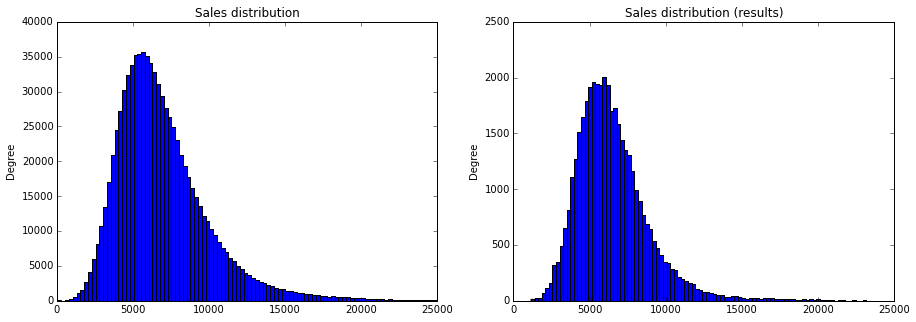

In [120]:
result_filename = "xgb1.csv"
filename = os.path.expandvars("%KagglePath%\\" + project_name + "\\results\\" + result_filename)
results = pd.read_csv(filename)
fig, axs = plt.subplots(1,2)
h = train[(train.Sales != 0) & (train.Sales < 25000)]["Sales"].plot(
    kind = "hist", bins=100, ax=axs[0], figsize=(15, 5), title="Sales distribution")
h = results[(results.Sales < 25000)]["Sales"].plot(
    kind = "hist", bins=100, ax=axs[1], title="Sales distribution (results)")

In [3]:
xgb1_val = pd.read_csv("xgb1_val_pre.csv")
xgb1_val.head(10)

,Unnamed: 0,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,...,Prev5Sales,Prev6Sales,Prev7Sales,Prev8Sales,Prev9Sales,Prev10Sales,Prev11Sales,Prev12Sales,Prev13Sales,Prev14Sales
0,0,1,5,2015-07-31,5263,555,1,1,0,1,...,0,4364,3706,3769,3464,3558,4395,0,4406,4852
1,1,2,5,2015-07-31,6064,625,1,1,0,1,...,0,2512,3854,4108,5093,3836,4435,0,3417,4518
2,2,3,5,2015-07-31,8314,821,1,1,0,1,...,0,3878,5080,5702,5414,5600,5798,0,4258,6679
3,3,4,5,2015-07-31,13995,1498,1,1,0,1,...,0,9322,8322,7286,8503,9176,10283,0,9703,10514
4,4,5,5,2015-07-31,4822,559,1,1,0,1,...,0,2030,3815,3713,3595,3497,4183,0,2108,4355
5,5,6,5,2015-07-31,5651,589,1,1,0,1,...,0,2892,3804,3482,3469,3720,4301,0,2915,4422
6,6,7,5,2015-07-31,15344,1414,1,1,0,1,...,0,6574,9203,9550,8214,9169,10159,0,6861,10339
7,7,8,5,2015-07-31,8492,833,1,1,0,1,...,0,3288,4917,6109,4996,5168,5956,0,3813,6728
8,8,9,5,2015-07-31,8565,687,1,1,0,1,...,0,5330,5464,6471,5649,5873,7152,0,5987,6845
9,9,10,5,2015-07-31,7185,681,1,1,0,1,...,0,4713,6152,6401,5561,6479,6111,0,5761,5356


In [4]:
def get_accuracy_by_store(storeData, val):
    errors = []
    for id in storeData:
        dt = val.loc[(xgb1_val.Store == id)]
        error = rmspe(dt.PredSales.values, dt.Sales.values)
        errors.append((id, error))
    return errors

In [5]:
accuracy_by_store = get_accuracy_by_store(storeData, xgb1_val)
accuracy_by_store_values = map(lambda x: x[1], accuracy_by_store)

NameError: name 'storeData' is not defined

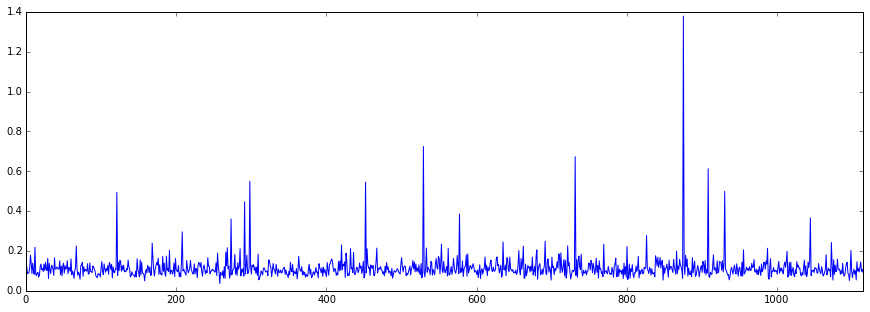

In [137]:
h = pd.Series(accuracy_by_store_values).plot(kind = "line", figsize=(15, 5))

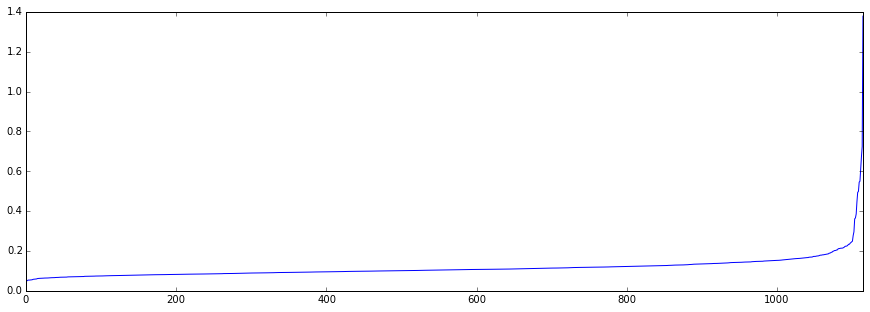

In [138]:
accuracy_by_store_values.sort()
h = pd.Series(accuracy_by_store_values).plot(kind = "line", figsize=(15, 5))

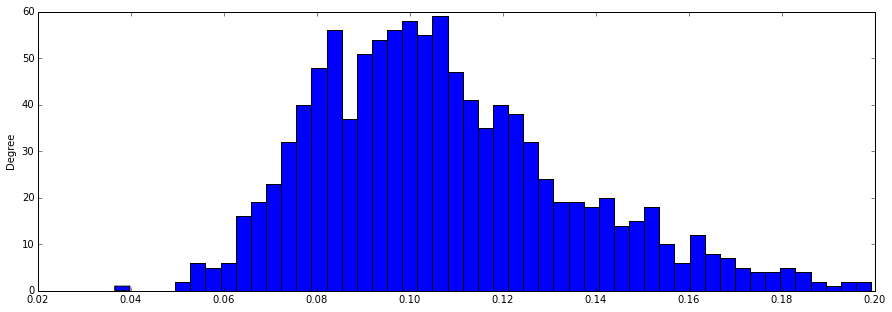

In [139]:
flt = []
for x in accuracy_by_store_values:
    if x < 0.2:
        flt.append(x)
pd.Series(flt).plot(kind = "hist", bins=50, figsize=(15, 5))

In [140]:
bad_count = 0
very_bad_count = 0
bad = []
very_bad = []
for id, value in accuracy_by_store:
    if value >= 0.12:
        bad_count += 1
        bad.append(id)
    if value >= 0.35:
        very_bad_count += 1
        very_bad.append((id, value))
print bad_count
print very_bad_count
print very_bad
print sum(map(lambda x: x[1], very_bad))/len(very_bad)

338
12
[(122L, 0.49382081905215447), (274L, 0.36082714118543852), (292L, 0.44671182012585153), (299L, 0.54970023642305454), (453L, 0.54527704446182057), (530L, 0.72426969146135578), (578L, 0.38540922100404684), (732L, 0.67299388891825129), (876L, 1.3781226437467144), (909L, 0.61191828897145684), (931L, 0.49886268899559705), (1045L, 0.36576339008301811)]
0.586139739536


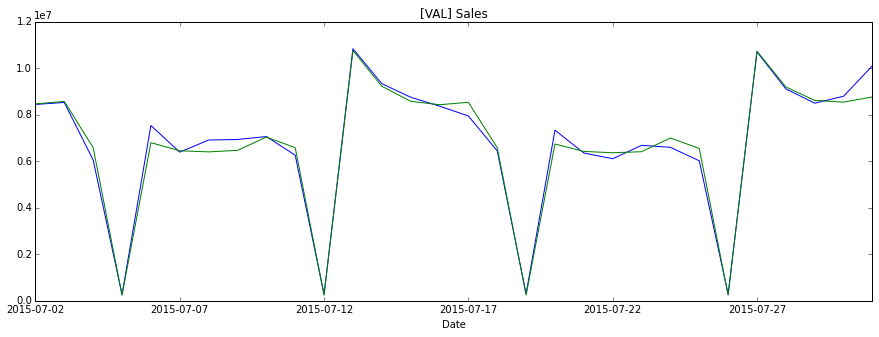

In [141]:
lst = xgb1_val.groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", title="[VAL] Sales", figsize=(15, 5))
lst = xgb1_val.groupby("Date")["PredSales"].sum()
h = lst.plot(kind = "line", figsize=(15, 5))

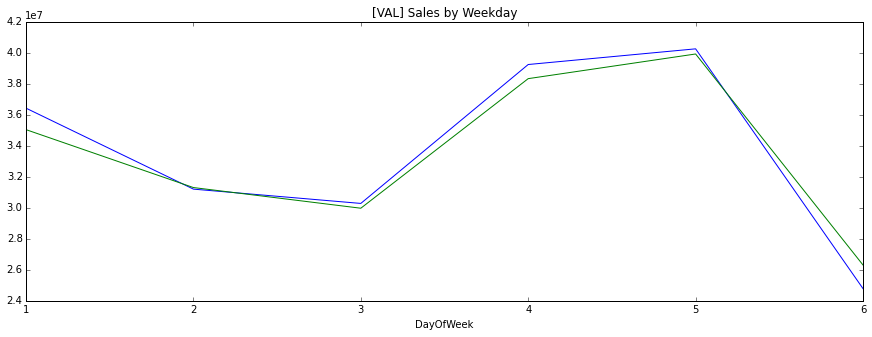

In [142]:
lst = xgb1_val[(xgb1_val["DayOfWeek"] != 7)].groupby("DayOfWeek")["Sales"].sum()
h = lst.plot(kind = "line", title="[VAL] Sales by Weekday", figsize=(15, 5))
lst = xgb1_val[(xgb1_val["DayOfWeek"] != 7)].groupby("DayOfWeek")["PredSales"].sum()
h = lst.plot(kind = "line", figsize=(15, 5))

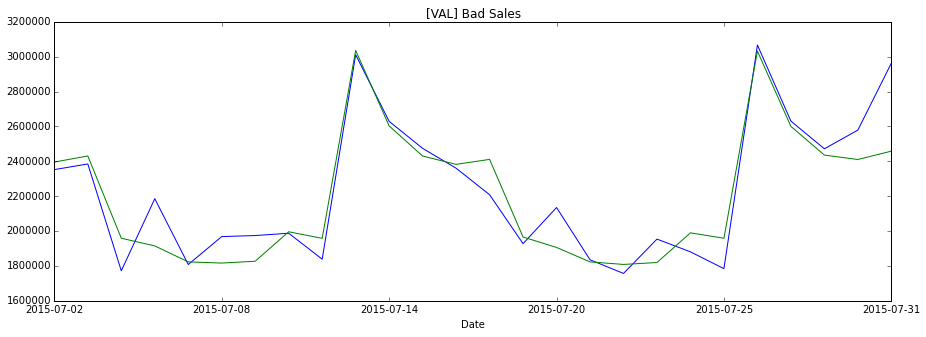

In [143]:
lst = xgb1_val[(xgb1_val['Store'].isin(bad)) & (xgb1_val["DayOfWeek"] != 7)].groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", title="[VAL] Bad Sales", figsize=(15, 5))
lst = xgb1_val[(xgb1_val['Store'].isin(bad)) & (xgb1_val["DayOfWeek"] != 7)].groupby("Date")["PredSales"].sum()
h = lst.plot(kind = "line", figsize=(15, 5))

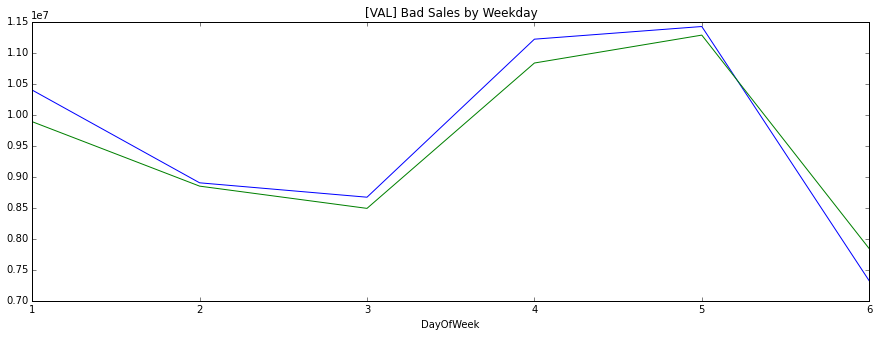

In [144]:
lst = xgb1_val[(xgb1_val['Store'].isin(bad)) & (xgb1_val["DayOfWeek"] != 7)].groupby("DayOfWeek")["Sales"].sum()
h = lst.plot(kind = "line", title="[VAL] Bad Sales by Weekday", figsize=(15, 5))
lst = xgb1_val[(xgb1_val['Store'].isin(bad)) & (xgb1_val["DayOfWeek"] != 7)].groupby("DayOfWeek")["PredSales"].sum()
h = lst.plot(kind = "line", figsize=(15, 5))

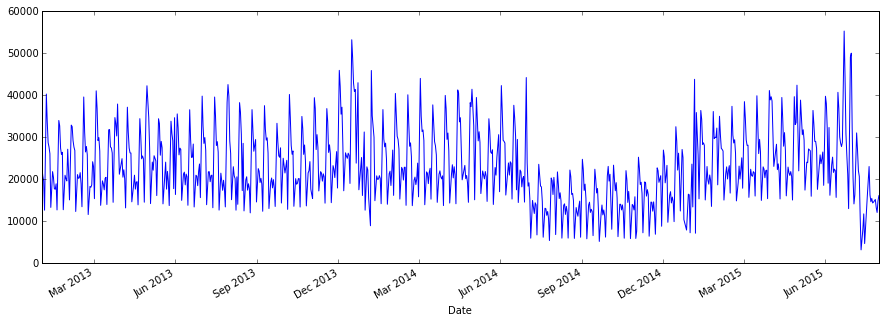

In [145]:
lst = train[(train.DayOfWeek != 7) & (train.Open == 1) & ((train.Store == 292L) | (train.Store == 876L) | (train.Store == 909L))].groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", figsize=(15, 5))

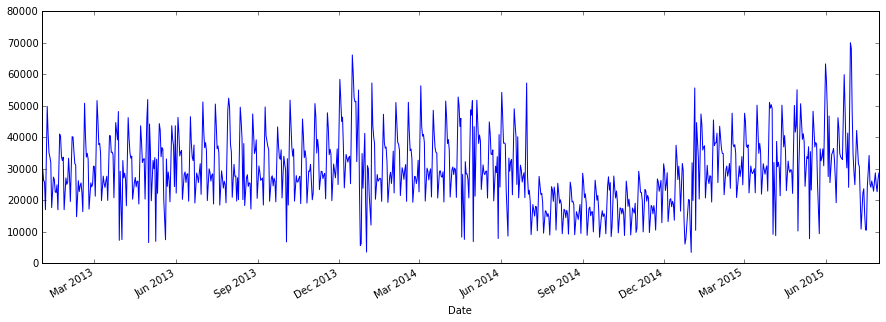

In [146]:
lst = train[(train.DayOfWeek != 7) & (train.Open == 1) & ((train.Store == 183L) | (train.Store == 274L) | (train.Store == 292L) | (train.Store == 876L) | (train.Store == 909L))].groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", figsize=(15, 5))

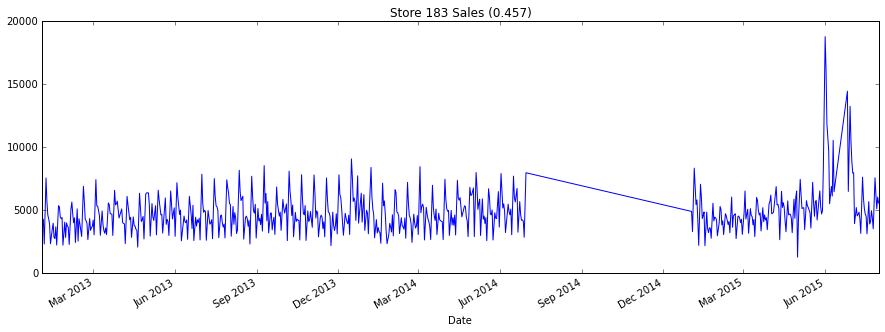

In [147]:
lst = train[(train.DayOfWeek != 7) & (train.Open == 1) & (train.Store == 183L)].groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", title="Store 183 Sales (0.457)", figsize=(15, 5))

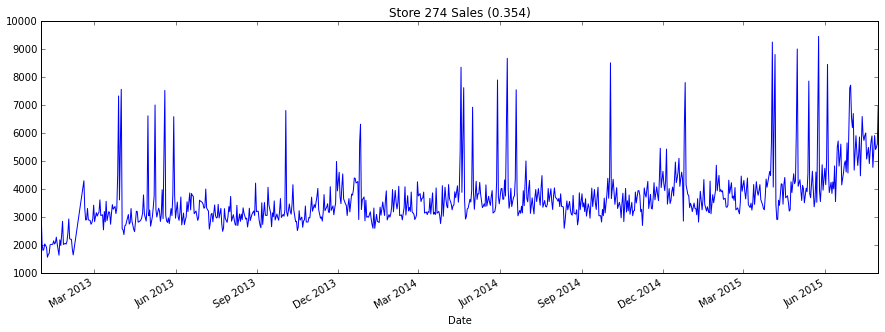

In [148]:
lst = train[(train.DayOfWeek != 7) & (train.Open == 1) & (train.Store == 274L)].groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", title="Store 274 Sales (0.354)", figsize=(15, 5))

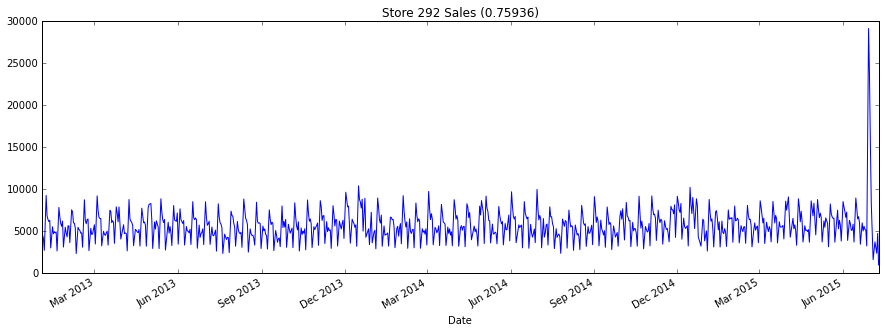

In [60]:
lst = train[(train.DayOfWeek != 7) & (train.Open == 1) & (train.Store == 292L)].groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", title="Store 292 Sales (0.75936)", figsize=(15, 5))

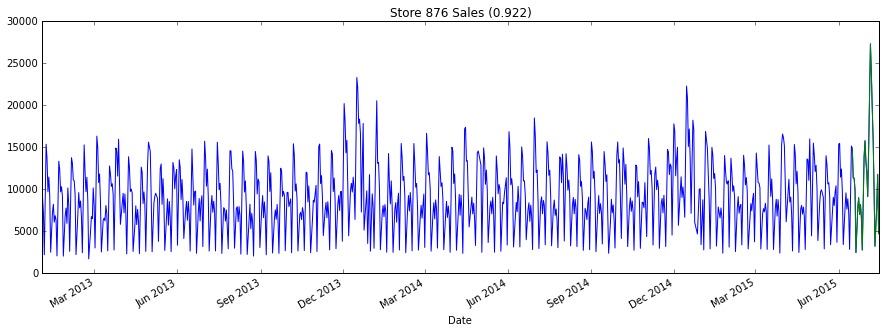

In [61]:
lst = train[(train.DayOfWeek != 7) & (train.Open == 1) & (train.Store == 876L)].groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", title="Store 876 Sales (0.922)", figsize=(15, 5))
lst = train[(train.Open == 1) & (train.Date > datetime.date(2015, 6, 15)) & (train.Store == 876L)].groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", figsize=(15, 5))

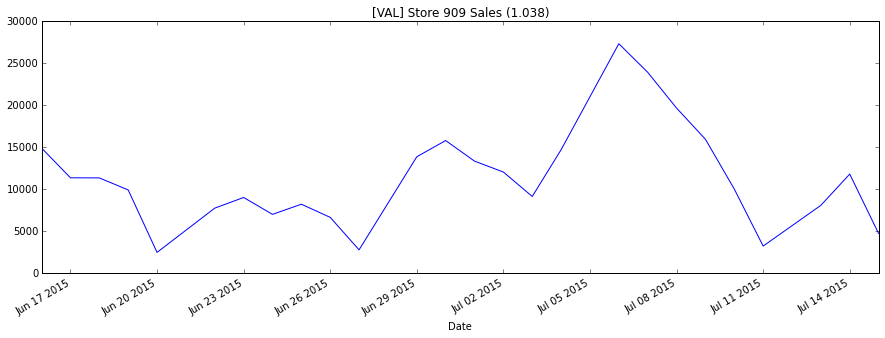

In [62]:
lst = train[(train.Open == 1) & (train.Date > datetime.date(2015, 6, 15)) & (train.Store == 876L)].groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", title="[VAL] Store 909 Sales (1.038)", figsize=(15, 5))

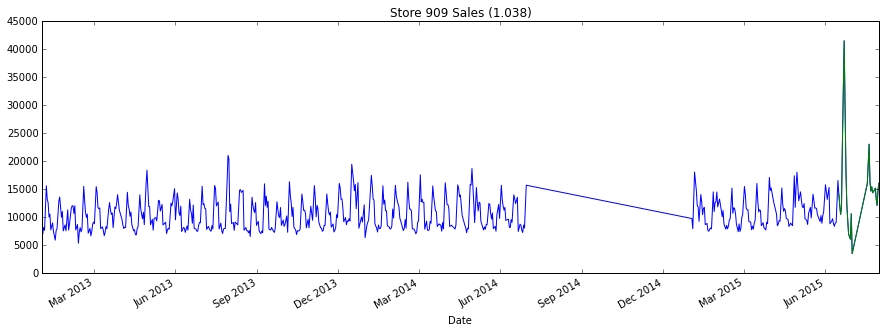

In [63]:
lst = train[(train.Open == 1) & (train.Store == 909L)].groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", title="Store 909 Sales (1.038)", figsize=(15, 5))
lst = train[(train.Open == 1) & (train.Date > datetime.date(2015, 6, 15)) & (train.Store == 909L)].groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", figsize=(15, 5))

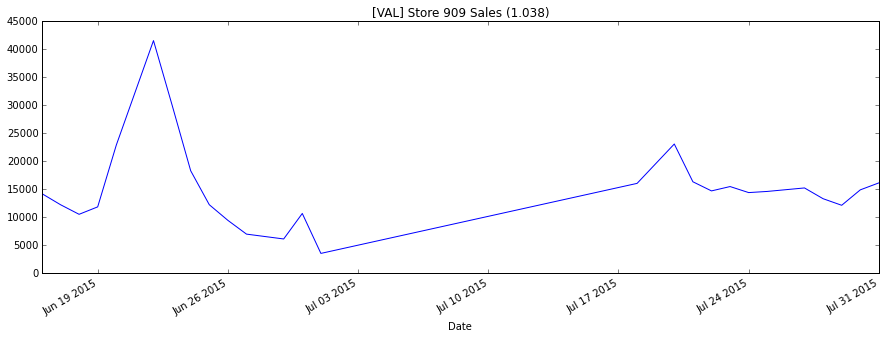

In [64]:
lst = train[(train.Open == 1) & (train.Date > datetime.date(2015, 6, 15)) & (train.Store == 909L)].groupby("Date")["Sales"].sum()
h = lst.plot(kind = "line", title="[VAL] Store 909 Sales (1.038)", figsize=(15, 5))